In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import torch
import yaml

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom import Mushroom

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


In [5]:
from mushroom.data.visium import get_common_channels, adata_from_visium
from mushroom.data.visium_v2 import get_section_to_image, format_expression
from mushroom.data.multiplex import write_basic_ome_tiff
import mushroom.utils as utils

In [6]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [7]:
def visium_to_ome(config, patch_size=32, visium_only=True):
    order = [entry['id'] for entry in config]
    fps = [entry['filepath'] for item in config for entry in item['data'] if entry['dtype']=='visium']
    channels = get_common_channels(fps, channel_mapping=None, pct_expression=.02)
    
    sid_to_filepaths = {item['id']:entry['filepath'] for item in config
                        for entry in item['data'] if entry['dtype']=='visium'}
    section_to_adata = {sid:adata_from_visium(fp, normalize=False) for sid, fp in sid_to_filepaths.items()}
    section_to_img, section_to_adata = get_section_to_image(
        section_to_adata, channels, channel_mapping=None, scale=.1
    )
    
    for sid in section_to_adata.keys():
        print(sid)
        index = order.index(sid)
        
        fp = sid_to_filepaths[sid]
        new_fp = fp.replace('.h5ad', '.ome.tiff')
                
        img, adata = section_to_img[sid], section_to_adata[sid]
        exp = format_expression(img, adata, patch_size)
        
        entry = config[index]
        for item in entry['data']:
            if item['dtype'] == 'visium':
                item['filepath'] = new_fp
                item['dtype'] = 'multiplex'
        
                write_basic_ome_tiff(new_fp, exp.numpy(), channels=channels)


    return config

In [128]:
for fp in config_fps:
    print(fp)
    config = yaml.safe_load(open(fp))
    config = visium_to_ome(config)
    fp = fp.replace('.yaml', '_visium_ome.yaml')
    yaml.safe_dump(config, open(fp, 'w'))

/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml
s0
s1
/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml
s0
s1
s2
s3
/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml
s0
s1
s2
s3
s4
/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml
s0
s1
/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml
s0
s1
/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml
s0
s1
s2
s3
/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml
s0
s1
/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml
s0
s1
s2
s3
s4
/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml
s0
s1
s2
s3
/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml
s0
s1
/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml
s0
s3
/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/conf

In [119]:
config

[{'data': [{'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT448C1/s0_visium_processed.ome.tiff'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT448C1/s1_visium_processed.ome.tiff'}],
  'id': 's1',
  'position': 60}]

In [8]:
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'_visium_ome.yaml$'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config_visium_ome.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config_visium_ome.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config_visium_ome.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config_visium_ome.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config_visium_ome.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config_visium_ome.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config_visium_ome.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config_visium_ome.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config_visium_ome.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config_visium_ome.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config_visium_ome.yaml',
 '/d

In [9]:
def grow_mushroom(mushroom_config, out_dir):
    
    mushroom = Mushroom.from_config(mushroom_config)
    mushroom.train()
    mushroom.embed_sections()
    
    return mushroom
    
    

In [10]:
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config_visium_ome.yaml'
config = yaml.safe_load(open(config_fps[0]))
case = config_fp.split('/')[-1]

out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}/outputs')
chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)


mushroom_config = {
    'dtype': 'multiplex',
    'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 8,
        'patch_size': 1,
        'triplet_scaler': 1.,
        'recon_scaler': 1.
    },
    'learner_kwargs': {
        'scale': 1.,
        'num_workers': 4,
        'channel_mapping': None,
        'batch_size': 32
    },
    'train_kwargs': {
        'num_iters': 1000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 100,
        'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
#         'background_channels': ['DAPI'],
        'span_all_sections': True
    }
}

In [11]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 14864 channels
INFO:root:2 sections detected: ['s0', 's1']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer
INFO:root:no background channel detected, defaulting to mean of all channels


In [12]:
mushroom.train()

INFO:root:iteration 0: {'overall_loss': tensor(1.6268, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.1107, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.5161, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/subclone/mushroom/config_visium_ome.yaml/outputs/chkpts/0iter.pt
INFO:root:iteration 10: {'overall_loss': tensor(1.6483, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.5419, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.1063, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 20: {'overall_loss': tensor(1.3613, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.2921, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0692, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 30: {'overall_loss': tensor(1.1229, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0469, device='cuda:0'

INFO:root:iteration 320: {'overall_loss': tensor(0.9744, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.9346, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0397, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 330: {'overall_loss': tensor(0.8011, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7481, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0530, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 340: {'overall_loss': tensor(0.8181, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7858, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0323, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 350: {'overall_loss': tensor(0.7585, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7412, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0173, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 360: {'o

INFO:root:iteration 670: {'overall_loss': tensor(1.0241, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(1.0039, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0202, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 680: {'overall_loss': tensor(0.7138, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.6792, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0346, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 690: {'overall_loss': tensor(0.5520, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.5501, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0019, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:iteration 700: {'overall_loss': tensor(0.7594, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7566, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0028, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint 

INFO:root:iteration 1000: {'overall_loss': tensor(0.7608, device='cuda:0', grad_fn=<AddBackward0>), 'recon_loss': tensor(0.7577, device='cuda:0', grad_fn=<DivBackward0>), 'triplet_loss': tensor(0.0031, device='cuda:0', grad_fn=<AddBackward0>)}
INFO:root:saving checkpoint to /data/estorrs/mushroom/data/projects/subclone/mushroom/config_visium_ome.yaml/outputs/chkpts/1000iter.pt
INFO:root:saving final checkpoint to /data/estorrs/mushroom/data/projects/subclone/mushroom/config_visium_ome.yaml/outputs/chkpts/final.pt


In [13]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/projects/subclone/mushroom/config_visium_ome.yaml/outputs/chkpts/final.pt'
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda
INFO:root:generating inputs for multiplex tissue sections
INFO:root:using 14864 channels
INFO:root:2 sections detected: ['s0', 's1']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer
INFO:root:no background channel detected, defaulting to mean of all channels


In [14]:
mushroom.embed_sections()

In [15]:
yaml.safe_dump(mushroom_config, open(os.path.join(out_dir, 'mushroom_config.yaml'), 'w'))

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's1'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

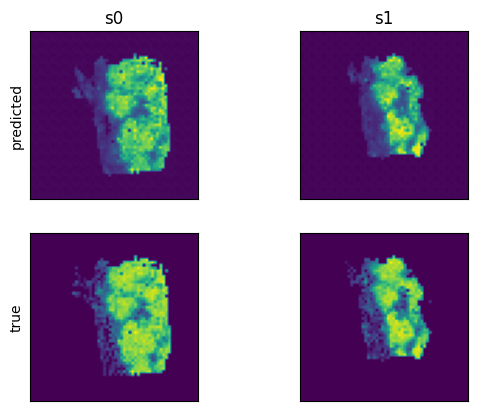

In [16]:
# mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's1'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

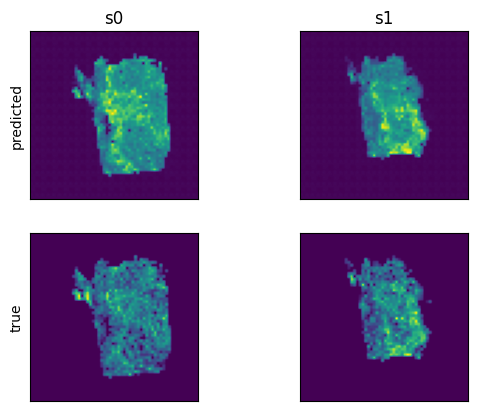

In [20]:
mushroom.display_predicted_pixels(channel='ACTA2')

In [26]:
mushroom.cluster_sections(margin=.05)

INFO:root:no background channel detected, defaulting to mean of all channels


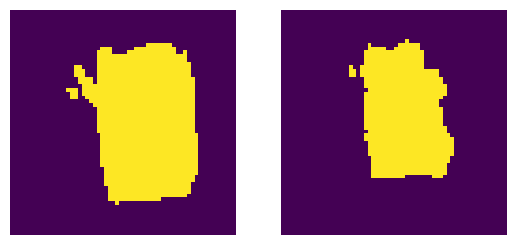

In [27]:
mushroom.clusterer.display_section_masks()

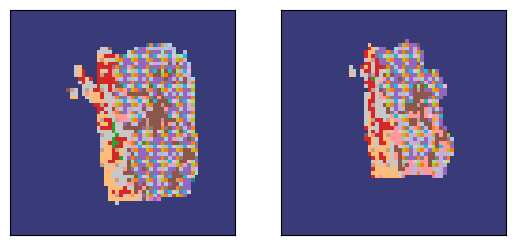

In [28]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

In [ ]:
mushroom_config['chkpt_filepath'] = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2/chkpts/400iter.pt'
mushroom = Mushroom.from_config(mushroom_config)

In [108]:
config = yaml.safe_load(open(config_fps[-3]))
config = visium_to_ome(config)

s0
s0 0 /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.h5ad /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.ome.tiff
s3
s3 3 /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.h5ad /data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.ome.tiff


In [109]:
config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium.h5ad'},
   {'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.ome.tiff'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 55},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium.h5ad'},
   {'dtype': 'visium_ome',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.ome.tiff'}],
  'id': 's3',
  'position': 100},
 {'data': [{'dtype': 'multiplex',
    'filepath